(13407, 15)


,event_type,count
0,Exploitive,6679
1,Disruptive,4158
2,Mixed,2400
3,Undetermined,170


<Axes: title={'center': 'Event‑type frequency'}, xlabel='event_type'>

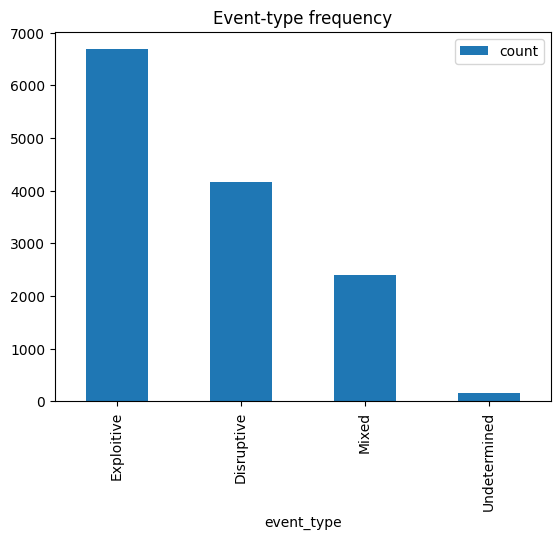

In [11]:
import pandas as pd
from datasets import load_dataset

ds= load_dataset("vinitvek/cybersecurityattacks")['train']

df= ds.to_pandas()

# basic shape
print(df.shape)

# label counts
label_counts = df["event_type"].value_counts().rename_axis("event_type").reset_index(name="count")
display(label_counts.head())

# bar chart
label_counts.plot(kind="bar", x="event_type", y="count", title="Event‑type frequency")

count    13407.000000
mean        24.436712
std         12.371409
min          2.000000
25%         16.000000
50%         22.000000
75%         30.000000
max        156.000000
Name: tok_len, dtype: float64


AttributeError: Rectangle.set() got an unexpected keyword argument 'title'

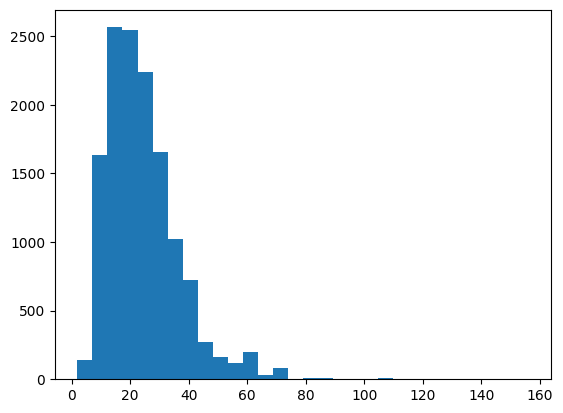

In [14]:
df["char_len"] = df["description"].str.len()
df["tok_len"]  = df["description"].str.split().apply(len)

print(df["tok_len"].describe())

df["tok_len"].hist(bins=30, title="Token length distribution")


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words="english", max_features=20000)
X = tfidf.fit_transform(df["description"])

top_n = 10
for label in df["event_type"].unique():
    rows = df["event_type"] == label
    mean_tfidf = X[rows].mean(axis=0).A1
    top_ids = mean_tfidf.argsort()[-top_n:][::-1]
    print(f"\nTop terms for {label}:")
    print([tfidf.get_feature_names_out()[i] for i in top_ids])


Top terms for Undetermined:
['cyber', 'cyberattack', 'hit', 'attack', 'incident', 'suffers', 'systems', 'confirms', 'network', 'discloses']

Top terms for Disruptive:
['attack', 'ddos', 'ransomware', 'hit', 'website', 'conducted', 'claims', 'websites', 'russian', '16']

Top terms for Mixed:
['ransomware', 'data', 'attack', 'site', 'gang', 'leak', 'dark', 'hit', 'web', 'network']

Top terms for Exploitive:
['data', 'breach', 'information', 'access', 'personal', 'email', '000', 'unauthorized', 'company', 'health']


<ipython-input-21-9fa970e0f7f1>:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  (df.resample("M")["event_type"]


<Axes: title={'center': 'Monthly volume by event type'}, xlabel='event_date'>

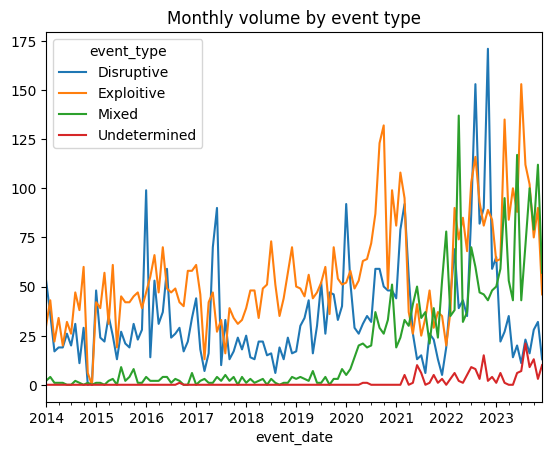

In [21]:
df.head(10)
df["event_date"] = pd.to_datetime(df["event_date"])
df.set_index("event_date", inplace=True)

(df.resample("M")["event_type"]
   .value_counts()
   .unstack(fill_value=0)
   .plot(title="Monthly volume by event type"))

In [1]:
ds = ds.shuffle(seed=42).train_test_split(test_size=0.2, seed=42)
label2id = {l:i for i,l in enumerate(ds['train'].unique('event_type'))}
id2label = {i:l for l,i in label2id.items()}
def prep(batch):
    batch["label"] = [label2id[t] for t in batch["event_type"]]
    return batch

ds = ds.map(prep, batched=True)

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
tok = AutoTokenizer.from_pretrained("markusbayer/CySecBERT")
def tokenize(batch):
    return tok(batch["description"], truncation=True, padding="max_length", max_length=128)

encoded = ds.map(tokenize, batched=True)

model = AutoModelForSequenceClassification.from_pretrained(
    "markusbayer/CySecBERT", num_labels=len(label2id),
    id2label=id2label, label2id=label2id
)

args = TrainingArguments(
    "cyberburst_ckpt", fp16=True, learning_rate=3e-5,
    per_device_train_batch_size=8, num_train_epochs=2
)

import evaluate, numpy as np
metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return metric.compute(predictions=preds, references=labels, average="weighted")

trainer = Trainer(model, args,
                  train_dataset=encoded['train'],
                  eval_dataset=encoded['test'],
                  compute_metrics=compute_metrics)

trainer.train()



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/30.0 [00:00<?, ?B/s]

collab%20dataset.csv:   0%|          | 0.00/6.29M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/13407 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/10725 [00:00<?, ? examples/s]

Map:   0%|          | 0/10725 [00:00<?, ? examples/s]

Map:   0%|          | 0/2682 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/321 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/10725 [00:00<?, ? examples/s]

Map:   0%|          | 0/2682 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/664 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at markusbayer/CySecBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: svyas (svyas-the-alan-turing-institute) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
500,0.566300
1000,0.438400
1500,0.398200
2000,0.313200
2500,0.313300


AttributeError: 'Trainer' object has no attribute 'save_pretrained'

In [3]:
metrics = trainer.evaluate(encoded["test"])
print(metrics)

{'eval_loss': 0.4097535312175751, 'eval_f1': 0.8774195117655677, 'eval_runtime': 9.6149, 'eval_samples_per_second': 278.943, 'eval_steps_per_second': 34.946, 'epoch': 2.0}


In [2]:
trainer.save_model("cyberburst_ckpt")
tok.save_pretrained("cyberburst_ckpt")

('cyberburst_ckpt/tokenizer_config.json',
 'cyberburst_ckpt/special_tokens_map.json',
 'cyberburst_ckpt/vocab.txt',
 'cyberburst_ckpt/added_tokens.json',
 'cyberburst_ckpt/tokenizer.json')

In [4]:
from sklearn.metrics import classification_report

preds = trainer.predict(encoded["test"]).predictions.argmax(-1)
y_true = encoded["test"]["label"]

print(classification_report(
    y_true, preds,
    target_names=[id2label[i] for i in range(len(id2label))]
))

              precision    recall  f1-score   support

  Disruptive       0.83      0.90      0.86       767
  Exploitive       0.94      0.95      0.94      1385
       Mixed       0.83      0.69      0.75       499
Undetermined       0.40      0.32      0.36        31

    accuracy                           0.88      2682
   macro avg       0.75      0.72      0.73      2682
weighted avg       0.88      0.88      0.88      2682



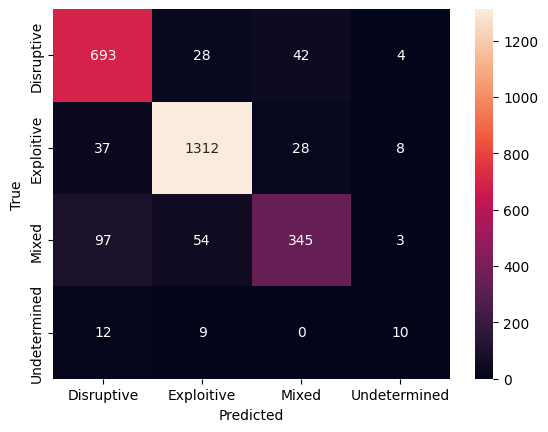

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, preds, labels=list(id2label.keys()))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=id2label.values(),
            yticklabels=id2label.values())
plt.ylabel("True")
plt.xlabel("Predicted")
plt.show()


In [6]:
import pandas as pd, numpy as np
test_texts = ds["test"]["description"]            # raw texts
bad = np.where(preds != y_true)[0]

for i in bad[:10]:
    print("❌ Pred:", id2label[preds[i]], "| True:", id2label[y_true[i]])
    print(test_texts[i][:200], "...\n")


❌ Pred: Mixed | True: Exploitive
British mesh fencing systems maker Zaun discloses a LockBit ransomware attack that potentially led to the compromise of data related to UK military and intelligence sites. ...

❌ Pred: Disruptive | True: Mixed
The technology system of the Superior Audit Office of Guanajuato (ASEG) suffered a ransomware attack that encrypted all the information of the system. ...

❌ Pred: Disruptive | True: Exploitive
Other #OpIsrael attacks: Anonymous, Anonymous Arabe, Anonymous Arab and AnonGhost deface several private domains and several governmental sites in addition to leaking data of Israeli citizens. ...

❌ Pred: Mixed | True: Disruptive
Bird Construction acknowledges to have been recently hit with a Maze ransomware attack. ...

❌ Pred: Mixed | True: Disruptive
Ukrainian software developer and IT services provider SoftServe suffers a RansomExx ransomware attack. ...

❌ Pred: Disruptive | True: Mixed
Oakbend Medical Center reveals to have been hit by a ransomware a